In [1]:
import numpy as np
import scipy
import scipy.stats
import pandas as pd
import astropy.units as u
import sunpy.map
import sunpy.visualization.colormaps as cm
import cv2
import skimage
import glob
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import random

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
sns.set_style("darkgrid")

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers

import autoenc_model as aem
import data_generator as dg
import utils

2023-04-07 19:15:31.969177: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/eugeniolr/.local/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github

In [2]:
batch_size = 50
gen_input = dg.SunImgAE3CGenerator("data/composite_data/", batch_size, test_split=0.2, shuffle=True, noise_filter=True)

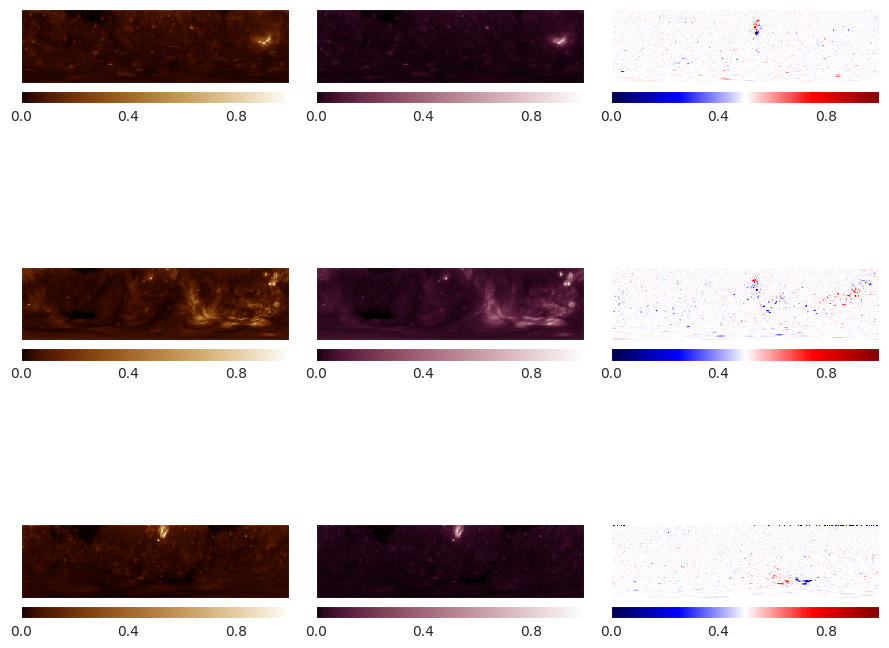

In [3]:
img_amount = 3

sample_images = gen_input.sample(img_amount)

image_list = []
for data_image in sample_images:
    for channel in data_image.transpose(2,0,1):
        image_list.append(channel)

isns.ImageGrid(image_list, cmap=["sdoaia193", "sdoaia211", "seismic"]*img_amount, orientation="h", vmin=0, vmax=1)


(200, 200) (100, 360)


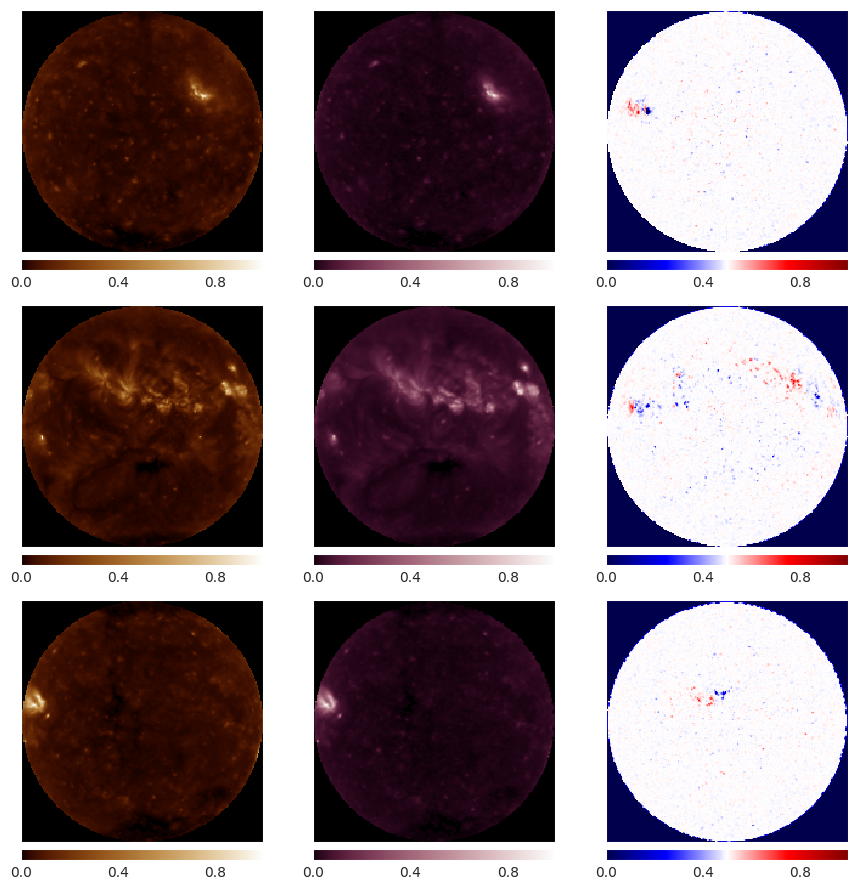

In [4]:
print(utils.polar_to_linear(image_list[0]).shape, image_list[0].shape)
ax = isns.ImageGrid(image_list.copy(), col_wrap=3, cmap=["sdoaia193", "sdoaia211", "seismic"]*img_amount, map_func=utils.polar_to_linear, orientation="h", vmin=0, vmax=1)

In [5]:
latent_size = 64
# optimizer = keras.optimizers.Adam(learning_rate=0.001)
# optimizer = keras.optimizers.SGD(learning_rate=0.01)
optimizer = keras.optimizers.RMSprop(learning_rate=0.001)

loss_fn = "mse"

autoencoder, encoder, decoder = aem.gen_xception_autoenc_3c(latent_size, optim=optimizer, loss=loss_fn)

2023-04-07 19:15:35.592869: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-07 19:15:35.611674: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-07 19:15:35.611867: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 360, 3  0           []                               
                                )]                                                                
                                                                                                  
 cylindrical_padding2d (Cylindr  (None, 100, 366, 3)  0          ['input_1[0][0]']                
 icalPadding2D)                                                                                   
                                                                                                  
 conv2d (Conv2D)                (None, 49, 182, 32)  864         ['cylindrical_padding2d[0][0]']  
                                                                                              

In [6]:
n_epochs = 125

history = autoencoder.fit(gen_input, epochs=n_epochs)

Epoch 1/125


/home/eugeniolr/Documents/master/TFM/data_generator.py:107: RuntimeWarning: All-NaN slice encountered
  min_values = np.nanmin(np.nanmin(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
/home/eugeniolr/Documents/master/TFM/data_generator.py:108: RuntimeWarning: All-NaN slice encountered
  max_values = np.nanmax(np.nanmax(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
/home/eugeniolr/Documents/master/TFM/data_generator.py:116: RuntimeWarning: All-NaN slice encountered
  hmi_max_values = np.nanmax(np.nanmax(np.abs(data_matrix[:,:,:,2]), axis=2, keepdims=True), axis=1, keepdims=True)
2023-04-07 19:15:37.930704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-07 19:15:44.772325: I tensorflow/compiler/xla/stream_e

359/359 [==============================] - 96s 229ms/step - loss: 0.0103 - mae: 0.0632
Epoch 2/125
359/359 [==============================] - 83s 230ms/step - loss: 0.0047 - mae: 0.0380
Epoch 3/125
359/359 [==============================] - 83s 232ms/step - loss: 0.0043 - mae: 0.0354
Epoch 4/125
359/359 [==============================] - 80s 222ms/step - loss: 0.0040 - mae: 0.0330
Epoch 5/125
359/359 [==============================] - 79s 220ms/step - loss: 0.0038 - mae: 0.0312
Epoch 6/125
359/359 [==============================] - 79s 220ms/step - loss: 0.0036 - mae: 0.0304
Epoch 7/125
359/359 [==============================] - 77s 215ms/step - loss: 0.0035 - mae: 0.0292
Epoch 8/125
359/359 [==============================] - 79s 221ms/step - loss: 0.0034 - mae: 0.0284
Epoch 9/125
359/359 [==============================] - 77s 215ms/step - loss: 0.0033 - mae: 0.0278
Epoch 10/125
359/359 [==============================] - 80s 221ms/step - loss: 0.0032 - mae: 0.0271
Epoch 11/125
359/359 

In [7]:
autoencoder.save("autoencoder_xception.h5")
encoder.save("encoder_xception.h5")
decoder.save("decoder_xception.h5")

2023-04-07 22:02:15.119784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


359/359 [==============================] - 83s 227ms/step - loss: 0.0014 - mae: 0.0177


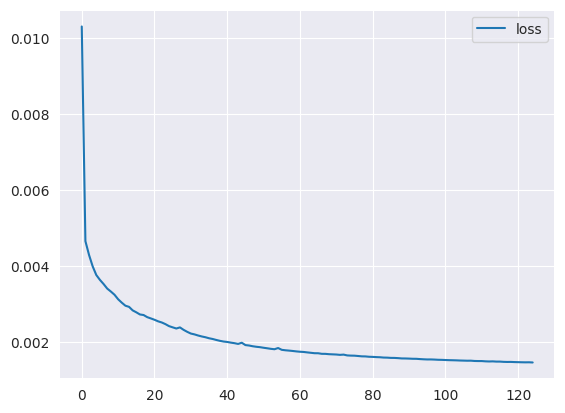

In [8]:
gen_input.training = False
autoencoder.evaluate(gen_input)
plt.plot(history.history['loss'], label='loss')
# plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

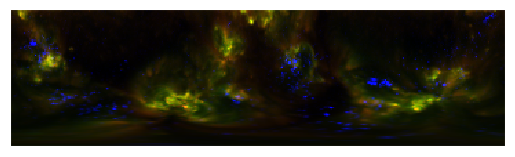

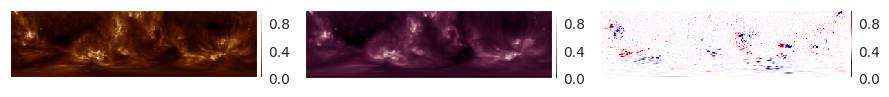

In [9]:
# test_img = np.array(random.choices(input_test, k=1))
test_img = gen_input.sample(1)

test_img_display = test_img[0].copy()
test_img_display[:,:,2] = np.abs((0.5 - test_img_display[:,:,2])*2)
isns.imgplot(test_img_display)
isns.rgbplot(test_img[0], cmap=["sdoaia193", "sdoaia211", "seismic"], vmin=0, vmax=1)

<AxesSubplot: >

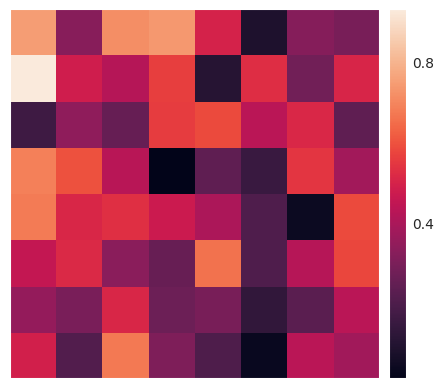

In [10]:
code = encoder(test_img)
# isns.imgplot(np.reshape(code[0], (6, 8)))
isns.imgplot(np.reshape(code[0], (8, 8)))

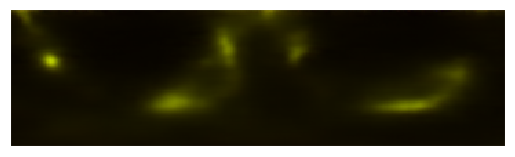

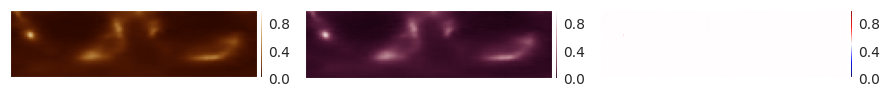

In [11]:
decoded = decoder(code)
decoded_display = np.copy(decoded[0])
decoded_display[:,:,2] = np.abs((0.5 - decoded_display[:,:,2])*2)
isns.imgplot(decoded_display)
isns.rgbplot(decoded[0], cmap=["sdoaia193", "sdoaia211", "seismic"], vmin=0, vmax=1)

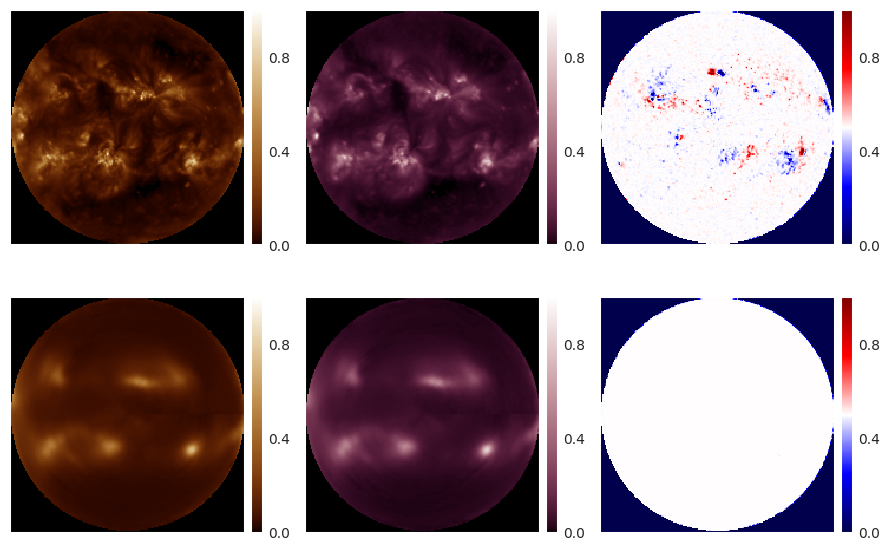

In [12]:
test_img_channels = [i for i in test_img[0].transpose(2,0,1)]

decoded_img_channels = [i for i in np.asarray(decoded[0]).transpose(2,0,1)]


isns.ImageGrid(test_img_channels+decoded_img_channels, cmap=["sdoaia193", "sdoaia211", "seismic"]*2, vmin=0, vmax=1, map_func=utils.polar_to_linear)